# AAPL time series modeling
### Comparing results of classical time series models with machine learning and deep learning models

Machine Learning and Deep Learning models have drawn attention in recent years for their impressive results on problems in Computer Vision, Natural Language Processing, and other areas. However, it is not clear whether ML/DL models outperform classical time series models.

In this notebook, we will model hand scraped Apple stock price data with a range of classical time series models as well as more sophisticated ML and DL models. We will fit the models in order of increasing complexity. Before moving on from a model we will try to optimize it using a hyperparameter grid search, after which the model will become our benchmark that will need to be passed by more sophisticated models. 

Part of the reason DL models have acheived better results in recent years is that technological advances in computing power and memory have made training these models more feasible, as they have many parameters and training them can be extremely computationally expensive. So for this kernel I am running a nohup job on a g2.2xlarge AWS Linux server. 

Hopefully we see better results from the more complex models and all these computations weren't in vain.


#### The general outline of the notebook is as follows:

1. Pull Apple stock price data using API
2. Exploratory data analysis<br> 
    a. Plot rolling mean and rolling variance<br> 
    b. Stationarity test (Augmented Dickey-Fuller test), Autocorrelation and Partial Autocorrelation plots to determine order of integration and parameters for ARIMA models<br>
3. Build model, grid search over hyperparameters to find best fit, and report results for the following models<br>
    a. Moving mean, moving median, and persistence models (baseline)<br>
    b. Holt-Winters Exponential Smoothing <br>
    c. SARIMA/ARIMA <br>
    d. Neural Network <br>
    e. Convolutional Neural Network <br>
    f. Long Short Term Memory (Recurrent Neural Network) <br>

#### Read in packages

In [1]:
# general packages
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
import matplotlib.pyplot as plt
import ast
import timeit

# math and stats packages
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array, mean, median, std
import warnings

# api related packages
import requests
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
import quandl

# settings
warnings.filterwarnings('ignore') #ignore annoying warning (from sklearn and seaborn)
%matplotlib inline
plt.style.use('seaborn')

#### Read-in data and set parameters

In [2]:
quandl.ApiConfig.api_key = "bhnUp4wu_kkHmzfasJWH"

In [3]:
def daily_price_historical(symbol, start_tup, end_tup = datetime.date.today()):
    year_s, month_s, day_s  = start_tup
    start = datetime.datetime(year_s, month_s, day_s)
    end = datetime.date.today()
    if end_tup != datetime.date.today():
        year_e, month_e, day_e = end_tup
        end = datetime.datetime(year_e, month_e, day_e)
    s = symbol
    stock = quandl.get("WIKI/" + s, start_date=start, end_date=end)
    df = stock[['Close']].rename(columns ={'Close':'Price'})
    print(end_tup)
    return df

In [4]:
# consider 'AAL' for non-differenced model
df = daily_price_historical('AAPL', (2016,9,21))

2019-11-19


In [5]:
#look at data
print('Max length = %s' % len(df))

# check head
df.head()

Max length = 379


,Price
Date,
2016-09-21,113.55
2016-09-22,114.62
2016-09-23,112.71
2016-09-26,112.88
2016-09-27,113.09


## EDA

Before we model our data let's take a quick look at our data:

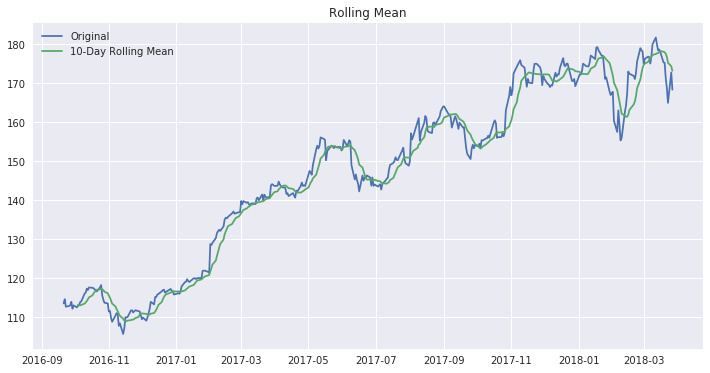

In [6]:
plt.figure(figsize=(12, 6))
rolmean = df['Price'].rolling(window=10).mean()
plt.plot(df['Price'], label='Original')
plt.plot(rolmean, label='10-Day Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

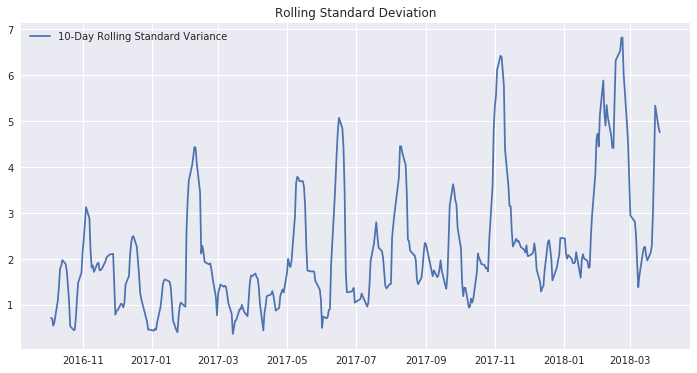

In [7]:
plt.figure(figsize=(12, 6))
rolvar = df['Price'].rolling(window=10).std()
plt.plot(rolvar, label='10-Day Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Standard Deviation')
plt.show(block=False)

### Stationarity

Generally, a process is considered stationary if its mean and variance constant over time. This is a very useful condition for time series forecasting because we can assume that the data we are predicting has the same statistical properties as the data we fit our model to. Unfortunately, in practice most time series are not stationary.

There are techniques for transforming time series data from non-stationary to stationary that we will explore when preparing data for some of our more sophisticated models. These techniques involve removing trend and seasonality. For now let's just check the stationarity of our data.

In [8]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

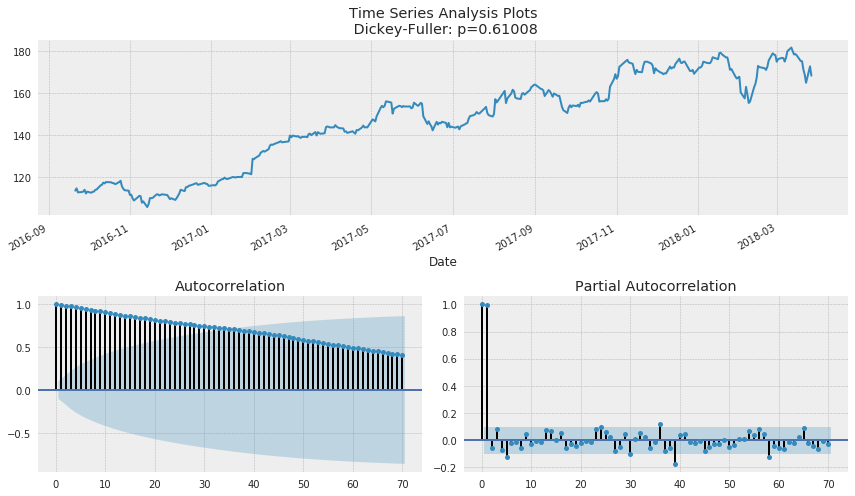

In [10]:
tsplot(df.Price, lags = 70)

With a p-value of <5% we would reject the null hypothesis that our data is non-stationary, but here we clearly can't do that with a p-value of ~61%, so we conclude out data non-stationary.

A couple definitions:
#### Autocorrelation:
> correlation of a signal with a delayed copy of itself as a function of delay.

#### Partial Autocorrelation: 
> correlation of a signal with a delayed copy of itself as a function of delay, controlling the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.


From the autocorrelation plot we see high autocorrelation out to the ~35 day time lag. From the partial autocorrelation plot we see that most of the autocorrelation is actually captured in the first lag.

We can also use these plots to detect seasonality, which we would detect by seeing spikes in the PACF at regular intervals, but that doesn't seem to be happening here and there is also no obvious pattern to suggest seasonality in our raw data. So, we can probably skip trying to account for seasonality in our models.

#### Making data stationary: Differencing

Since our data is non-stationary (i.e. has non-constant mean and variance) we are going to want to make it stationary before we build models. Note: another solution might be finding a stationary time series to begin with, but that might be hard if we want to find a sufficient amount of data to train our neural networks on, because they require a lot of data.

One way to make some time series stationary is to compute the differences between consecutive observations. This is known as differencing, let's do that below

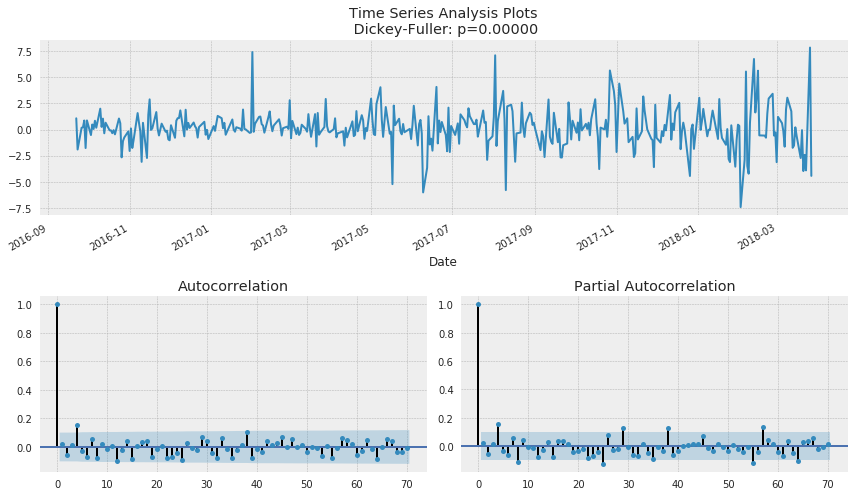

In [11]:
# difference data
price_diff = df.Price - df.Price.shift()

# plot differenced data
tsplot(price_diff[1:], lags=70)

With a p-value of <5% we can reject the null hypothesis that our data is non-stationary, therefore our data is now stationary.

The ARIMA (Autoregresive integrated moving average) and SARIMA (seasonal ARIMA) models parameters can be inferred using these plots. More on [ARIMA models](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).

Below are what we would expect for our SARIMA parameters fit on our data:

>(p) is most likely 0 since it is the last significant lag on the PACF, after which, most others are not significant. Possible it is 4 or 8.

>(d) equals 1 because we had a time series integrated of order 1 (i.e, our data is I(1)).

>(q) is most likely 0 as seen on the ACF. Possible 4 would work well.

>(P) most likely 0 because we don't see seasonality.

>(D) most likely 0 because we don't see seasonality.

>(Q) most likely 0 because we don't see seasonality.

So we are not getting a lot of information about what our best model parameters will be, let's see what our grid searches come up with.

# Modeling

Need a few more packages for modeling:

In [12]:
# import a few more package for time series models
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
#models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore') #ignore annoying warning (from sklearn and seaborn)

We want to evaluate different configurations of the following models: 
1. Best of moving mean, moving median, and persistence models (baseline)
2. EMA <br>
3. SARIMA/ARIMA <br>
4. Neural Network
5. Convolutional Neural Network <br>
6. Long Short Term Memory (Recurrent Neural Network) <br>
    
We will optimize our models by defining a set of functions that allow us to train, forecast, and validate (via the gold standard of walk forward validatiaon) a model over a range of hyperparameters. After finding the model's best hyperparameter combination, we will remark how they might differ from our expectations. Finally, we will plot the forecast from our best model and report our Root Mean Squared Error so we may use it as a benchmark for our next, more sophisticated model.

#### Set of functions that can used across models

In [13]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, model, plot = False):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    # create results dataframe for top score
    if plot == True:
        cfg_data.update({"{}".format(cfg):[history, test, predictions]})
        results_df['train'] = [item for sublist in cfg_data["{}".format(cfg)][0] for item in sublist]
        results_df['test']  = [None for i in range(len(df) - len(cfg_data["{}".format(cfg)][1]))] + [item for sublist in cfg_data["{}".format(cfg)][1] for item in sublist]
        results_df['forecast']  = [None for i in range(len(df) - len(cfg_data["{}".format(cfg)][2]))] + cfg_data["{}".format(cfg)][2]
        results_df['forecast'] = results_df['forecast'].apply(lambda x: None if x == None else x[0])
        results_df.set_index(df.index, inplace = True)
    return error 

# score a model, return None on failure
def score_model(data, n_test, cfg, model, plot = False, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg, model, plot)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg, model, plot)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, model, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, model) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, model) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores



## Baseline model

#### Define simple forecast model
Model below is acutally three different models, depending on the hyperparameter:
1. Persistence: prediction is equal to lag of n
2. Mean: prediction is equal to the mean of last n values
3. Median: prediction is equal to the median of last n values
    
Either way, after grid searching we will find the best model out of all persistence, moving mean, and moving median models  ```
for n=1 to n=len(training_data)
```

In [14]:
# one-step simple forecast
def simple_forecast(history, config):
    n, offset, avg_type = config
    # persist value, ignore other config
    if avg_type == 'persist':
        return history[-n]
    # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean':
        return mean(values)
    # median of last n values
    return median(values)

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs

#### Run baseline models

In [15]:
# prepare dataset
data = df.values

# data split
n_test = int(len(data) * .2)

In [16]:
# find max length for moving avg parameter (i.e. len of test data)
max_length = len(data) - n_test

# create hyperparameter configs
cfg_list = simple_configs(max_length)
print('Grid search {} configs for simple_forecast'.format(len(cfg_list)))

Grid search 912 configs for simple_forecast


In [17]:
%%capture
start_time = timeit.default_timer()

# grid search 912 different models 
scores = grid_search(data, cfg_list, n_test, simple_forecast)

In [18]:
elapsed = timeit.default_timer() - start_time
print("Grid search took %.3f seconds" % (elapsed))

Grid search took 6.838 seconds


In [19]:
# list top 3 configs
print('Top 3 scores for simple forecast:')
for cfg, error in scores[:3]:
    print(cfg, error)

Top 3 scores for simple forecast:
[1, 1, 'persist'] 2.607550288425262
[2, 1, 'mean'] 2.9043057827990504
[2, 1, 'median'] 2.9043057827990504


In [20]:
# create empty dict and dataframe to store best result
results_df = pd.DataFrame()
cfg_data = {}
top_score = score_model(data, n_test, ast.literal_eval(scores[0][0]), simple_forecast, plot = True)

 > Model[[1, 1, 'persist']] 2.608


Our best baseline forecast turns out to be predicting tomorrow's price is the same as todays. Doesn't look like too bad of a model, but suffers from a very serious autocorrelation problem.

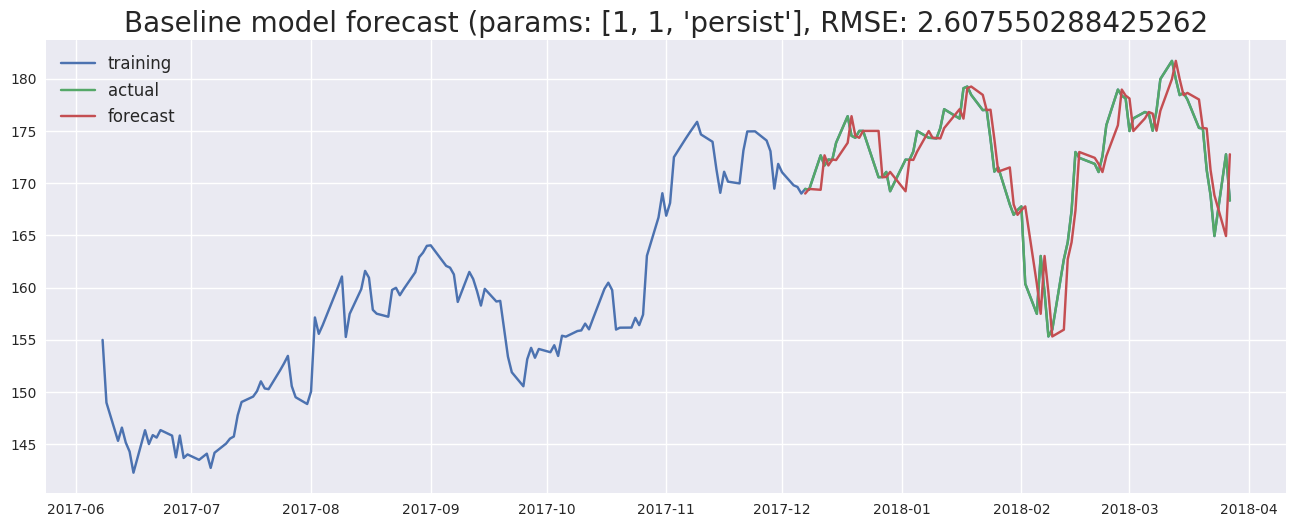

In [21]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(results_df.train[-200:], label='training')
plt.plot(results_df.test, label='actual')
plt.plot(results_df.forecast, label='forecast')
plt.title('Baseline model forecast (params: {}, RMSE: {}'.format(scores[0][0],scores[0][1]), fontsize = 20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

We can see that the best result was an RMSE of ~2.608 dollars, acheived by predicting tomorrow's price is the same as today's. This is somewhat surprising given the stong upward trend 

### Holt Winter's Exponential Smoothing Forecast
Below we set up a test harness for an [Exponential Smoothing model](https://otexts.com/fpp2/holt-winters.html) and forecast.
We will grid search over the following parameters:
1. trend(t): The type of trend component, as either add for additive or mul for multiplicative. Modeling the trend can be disabled by setting it to None.
2. damped(d): Whether or not the trend component should be damped, either True or False.
3. seasonal(s): The type of seasonal component, as either add for additive or mul for multi-plicative. Modeling the seasonal component can be disabled by setting it to None.
4. seasonal periods(p): The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
5. use boxcox(b): Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

#### Define model and hyperparameter config func

In [22]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t, d, s, p, b, r]
                            
                            models.append(cfg)
    return models

In [23]:
# model configs
cfg_list = exp_smoothing_configs()
print('Grid search {} configs for exp_smoothing_forecast'.format(len(cfg_list)))

Grid search 72 configs for exp_smoothing_forecast


In [24]:
%%capture
start_time = timeit.default_timer()

# grid search 72 model configs
scores = grid_search(data, cfg_list, n_test, exp_smoothing_forecast)

In [25]:
elapsed = timeit.default_timer() - start_time
print("Grid search took %.3f seconds" % (elapsed))

Grid search took 203.704 seconds


In [26]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[None, False, None, None, True, False] 2.6075502884252617
[None, False, None, None, False, False] 2.607550288425262
['add', False, None, None, True, True] 2.6142882355840364


In [27]:
# create empty dict and dataframe to store best result
results_df = pd.DataFrame()
cfg_data = {}
top_score = score_model(data, n_test, ast.literal_eval(scores[0][0]), exp_smoothing_forecast, plot = True)

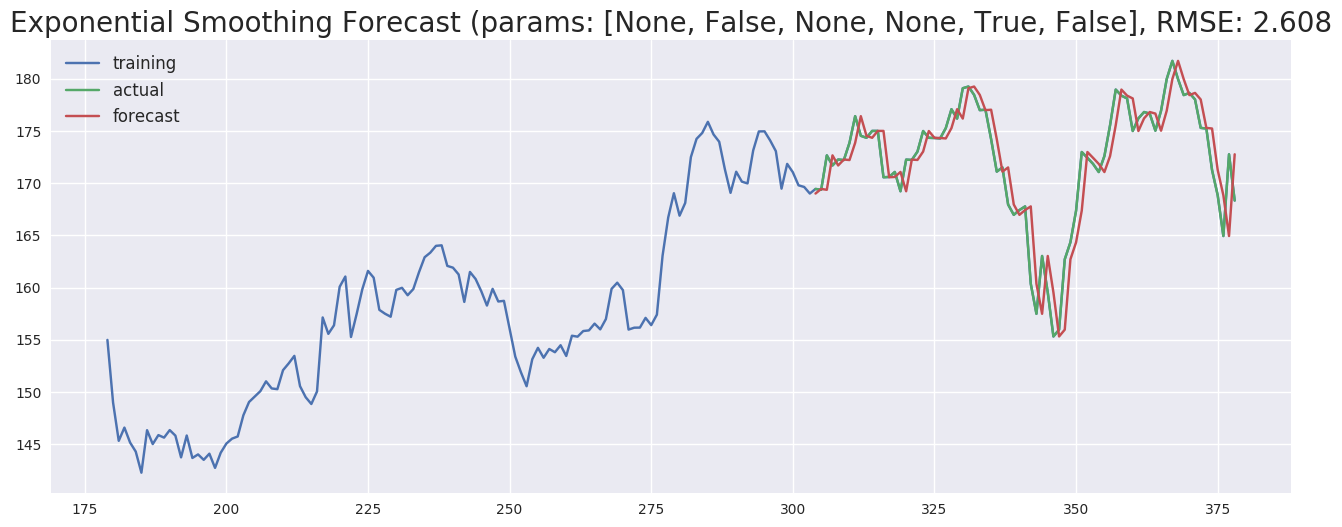

In [28]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(results_df.train[-200:], label='training')
plt.plot(results_df.test, label='actual')
plt.plot(results_df.forecast, label='forecast')
plt.title('Exponential Smoothing Forecast (params: %s, RMSE: %.3f' % (scores[0][0],scores[0][1]), fontsize = 20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

We can see that the best result was an RMSE of ~2.608 dollars, which is the same as our last model. The optimal parameters seem to be very simple; the same persistence model as above, only with a box cox transformation applied, which is typically used to make left skewed data more normal.

So far the simplest version of the models seem to be winning.

### Seasonal Autoregressive Integrated Moving Average Forecast
Below we set up a test harness for an [SARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and forecast.
We will grid search over the following parameters:
1. p: Trend autoregression order.
2. d: Trend difference order.
3. q: Trend moving average order.
4. P: Seasonal autoregressive order.
5. D: Seasonal difference order.
6. Q: Seasonal moving average order.
7. m: The number of time steps for a single seasonal period.

Below we define SARIMA model and hyperparameter configuration grid search

In [29]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [30]:
# model configs
cfg_list = sarima_configs()
print('Grid search {} configs for sarima_forecast'.format(len(cfg_list)))

Grid search 1296 configs for sarima_forecast


In [31]:
%%capture
start_time = timeit.default_timer()

# grid search 1296 model configs
scores = grid_search(data, cfg_list, n_test, sarima_forecast)

In [32]:
elapsed = timeit.default_timer() - start_time
print("Grid search took %.3f seconds" % (elapsed))

Grid search took 31013.881 seconds


In [33]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

[(2, 0, 2), (2, 0, 1, 0), 'ct'] 2.5325551777938515
[(2, 1, 0), (0, 0, 2, 0), 'n'] 2.57196944623253
[(0, 1, 2), (2, 0, 0, 0), 'n'] 2.572482520086538


In [34]:
results_df = pd.DataFrame()
cfg_data = {}
top_score = score_model(data, n_test, ast.literal_eval(scores[0][0]), sarima_forecast, plot = True)

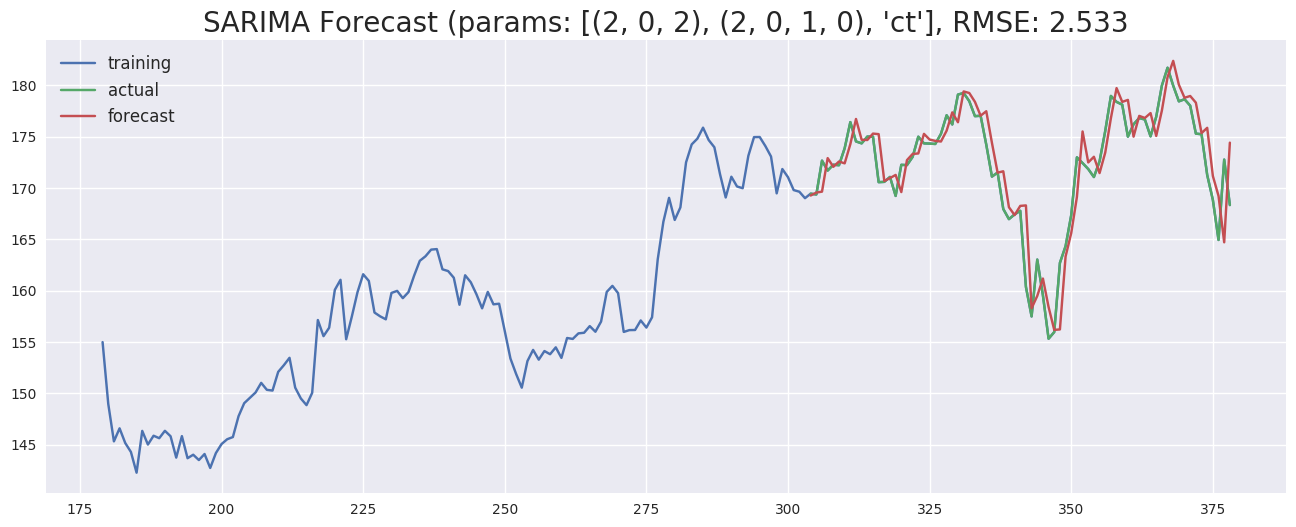

In [35]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(results_df.train[-200:], label='training')
plt.plot(results_df.test, label='actual')
plt.plot(results_df.forecast, label='forecast')
plt.title('SARIMA Forecast (params: %s, RMSE: %.3f' % (scores[0][0],scores[0][1]), fontsize = 20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

### SARIMA optimal model review 
I am surpised at the optimal set of hyperparameters for our SARIMA model.

>(p) Using the auto-correlation plots, I guessed p would be 0, 4, or 8, and instead it is 2.

>(d) I guessed d would be 1 because it appeared our time series was of integrated of order 1 (i.e, our data is I(1)), but here it is 0.

>(q) I guessed q would be 0 and instead it is 2.

>(P, D, Q) I guessed (P, D, Q) would be (0, 0, 0) because our series didn't look seasonal, but instead we got (2, 0 , 1).

> We also see the parameter 'ct' for constant with linear trend, our undifferenced data clearly has a fairly linear upward trend, so I cna see why this worked well in our model.

### Neural Network

Below we build a Neural Network using keras.
Our basic NN will have one hidden layer and we will grid search over the following parameters:
1. number time steps in input
2. number of nodes in hidden layer 
3. number of epochs to train
4. number of observations within after which weights are updated (batch size)
5. number of time lags to difference on

In [36]:
#import NN packages
from keras.models import Sequential
from keras.layers import Dense


# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    # shape input for model
    x_input = array(history[-n_input:]).reshape((1, n_input))
    # make forecast
    yhat = model.predict(x_input, verbose=0)
    # correct forecast if it was differenced
    return correction + yhat[0]

# walk-forward validation for neural nets
def walk_forward_validation(data, n_test, cfg, plot = False):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    # create results dataframe for top score
    if plot == True:
        cfg_data.update({"{}".format(cfg):[history, test, predictions]})
        results_df['train'] = [item for sublist in cfg_data["{}".format(cfg)][0] for item in sublist]
        results_df['test']  = [None for i in range(len(df) - len(cfg_data["{}".format(cfg)][1]))] + [item for sublist in cfg_data["{}".format(cfg)][1] for item in sublist]
        results_df['forecast']  = [None for i in range(len(df) - len(cfg_data["{}".format(cfg)][2]))] + cfg_data["{}".format(cfg)][2]
        results_df['forecast'] = results_df['forecast'].apply(lambda x: None if x == None else x[0])
        results_df.set_index(df.index, inplace = True)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test,  plot = False, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config, plot) for _ in range(n_repeats)]
    # summarize score
    result = mean(scores)
    print('> Model[%s] mean score: %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, plot = False):
    # evaluate configs
    scores = scores = [repeat_evaluate(data, cfg, n_test, plot) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [1, 5, 10]
    n_nodes = [50, 100]
    n_epochs = [100, 150]
    n_batch = [1, 100]
    n_diff = [0, 1]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

# summarize model performance
def summarize_scores(name, scores):
    scores_lst = [score[1] for score in scores] 
    # print a summary
    scores_m, score_std = mean(scores_lst), std(scores_lst)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.figure(figsize=(6, 5), dpi=100)
    plt.boxplot(scores_lst)
    plt.show()

Using Theano backend.
Using cuDNN version 5103 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)


In [37]:
# model configs
cfg_list = model_configs()

Total configs: 48


In [38]:
%%capture
start_time = timeit.default_timer()

# grid search
scores = grid_search(data, cfg_list, n_test)

In [39]:
elapsed = timeit.default_timer() - start_time
print("Grid search took %.3f seconds" % (elapsed))

Grid search took 8318.328 seconds


[1, 50, 150, 100, 0] 2.60484754930078
[1, 100, 100, 100, 0] 2.6065787326446066
[1, 50, 100, 100, 0] 2.6088184677494466

 Neural Network: 3.159 RMSE (+/- 0.721)


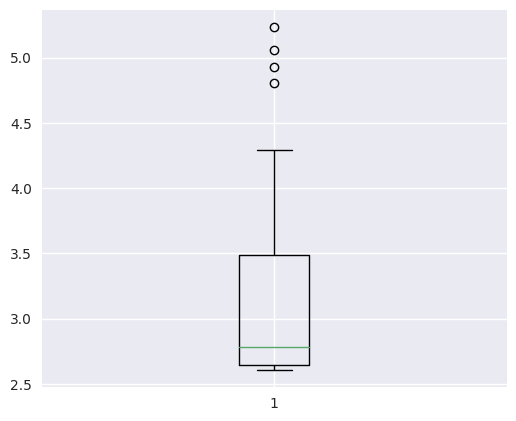

In [40]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)
    
# summarize scores
summarize_scores('\n Neural Network', scores)

In [41]:
results_df = pd.DataFrame()
cfg_data = {}
top_score = grid_search(data, [ast.literal_eval(scores[0][0])], n_test, plot = True)

> Model[[1, 50, 150, 100, 0]] mean score: 2.606


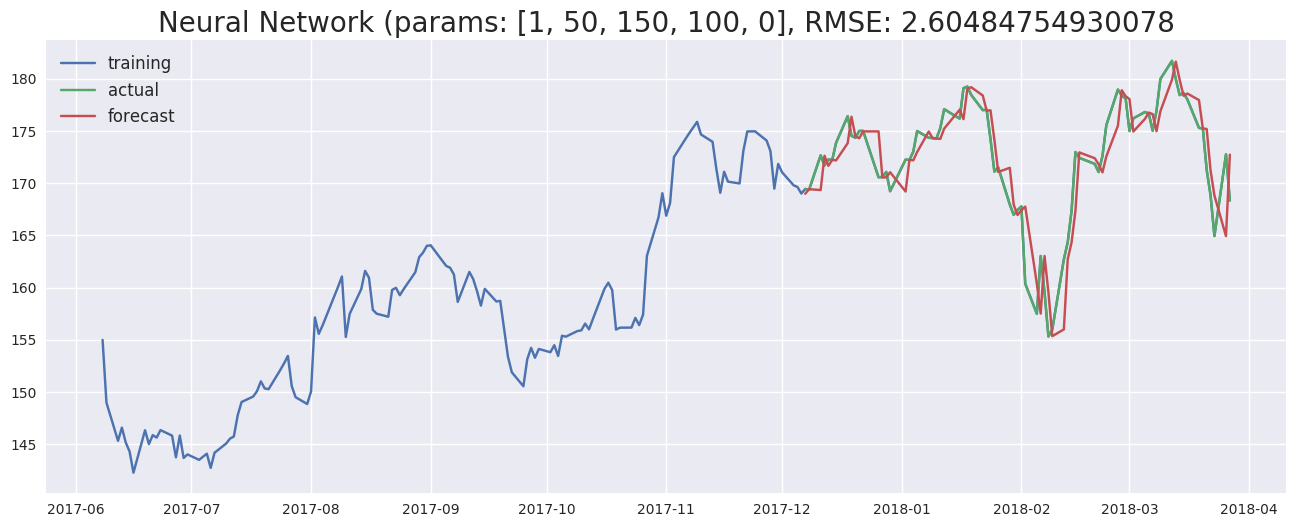

In [42]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(results_df.train[-200:], label='training')
plt.plot(results_df.test, label='actual')
plt.plot(results_df.forecast, label='forecast')
plt.title('Neural Network (params: {}, RMSE: {}'.format(scores[0][0],scores[0][1]), fontsize = 20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Optimal hyperparameter review
1. 1 lag observation used as an input to the model is a bit surpising snce you think a sophisticated model might have a longer lookback.
2. All else equal, 100 nodes performing beter than 50 is pretty intuitive, might want to check for overfitting.
3. 100 training epochs was our only choice for this hyperparameter, might want to ad some more values in between.
4. All else equal, a batch size of 100 outperforming batch size of 1 is not too surprising, might want to get more granular with these hyperparameters.
5. Surprised to see the best config for this I(1) series did not included any differencing.

### Convolutional Neural Network

Below we build a Convolution Neural Network 
Our CNN will have one convolutional layer, one pooling layer, one flattening layer, and we will grid search over the following parameters:
1. number of lag observations to use as input to the model.
2. number of filters in convolutional layer 
3. size of filters in convolutional layer
3. number of epochs to train
4. number of observations trained after which weights are updated
5. number of time lags to difference on


In [43]:
# grid search cnn 
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, n_features)))
    model.add(Conv1D(n_filters, n_kernel, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]


# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_filters = [64]
    n_kernels = [3, 5]
    n_epochs = [100, 150]
    n_batch = [1, 100, 150]
    n_diff = [0, 1]
    # create configs
    configs = list()
    for a in n_input:
        for b in n_filters:
            for c in n_kernels:
                for d in n_epochs:
                    for e in n_batch:
                        for f in n_diff:
                            cfg = [a,b,c,d,e,f]
                            configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs


In [44]:
# model configs
cfg_list = model_configs()

Total configs: 24


In [45]:
# %%capture
start_time = timeit.default_timer()

# grid search
scores = grid_search(data, cfg_list, n_test)

> Model[[12, 64, 3, 100, 1, 0]] mean score: 4.638
> Model[[12, 64, 3, 100, 1, 1]] mean score: 3.601
> Model[[12, 64, 3, 100, 100, 0]] mean score: 6.162
> Model[[12, 64, 3, 100, 100, 1]] mean score: 3.503
> Model[[12, 64, 3, 100, 150, 0]] mean score: 6.130
> Model[[12, 64, 3, 100, 150, 1]] mean score: 3.400
> Model[[12, 64, 3, 150, 1, 0]] mean score: 4.620
> Model[[12, 64, 3, 150, 1, 1]] mean score: 3.634
> Model[[12, 64, 3, 150, 100, 0]] mean score: 6.252
> Model[[12, 64, 3, 150, 100, 1]] mean score: 3.800
> Model[[12, 64, 3, 150, 150, 0]] mean score: 6.320
> Model[[12, 64, 3, 150, 150, 1]] mean score: 3.664
> Model[[12, 64, 5, 100, 1, 0]] mean score: 3.692
> Model[[12, 64, 5, 100, 1, 1]] mean score: 3.621
> Model[[12, 64, 5, 100, 100, 0]] mean score: 6.207
> Model[[12, 64, 5, 100, 100, 1]] mean score: 3.573
> Model[[12, 64, 5, 100, 150, 0]] mean score: 6.356
> Model[[12, 64, 5, 100, 150, 1]] mean score: 3.528
> Model[[12, 64, 5, 150, 1, 0]] mean score: 3.541
> Model[[12, 64, 5, 150, 1

In [46]:
elapsed = timeit.default_timer() - start_time
print("Grid search took %.3f seconds" % (elapsed))

Grid search took 6789.880 seconds


[12, 64, 3, 100, 150, 1] 3.39963902738112
[12, 64, 3, 100, 100, 1] 3.5025630290031033
[12, 64, 5, 100, 150, 1] 3.5275453688700393
Convolutional NN: 4.579 RMSE (+/- 1.216)


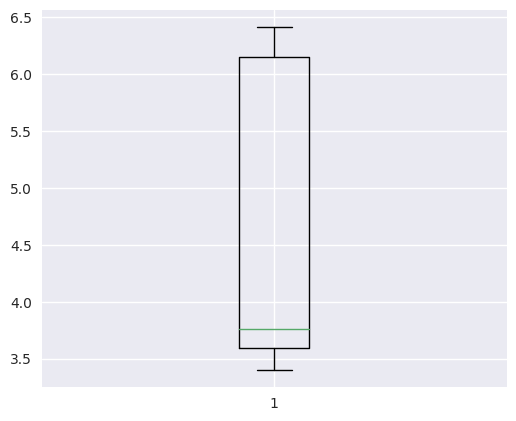

In [47]:
# list top 10 configs
for cfg, error in scores[:3]:
    print(cfg, error)
    
# summarize scores
summarize_scores('Convolutional NN', scores)

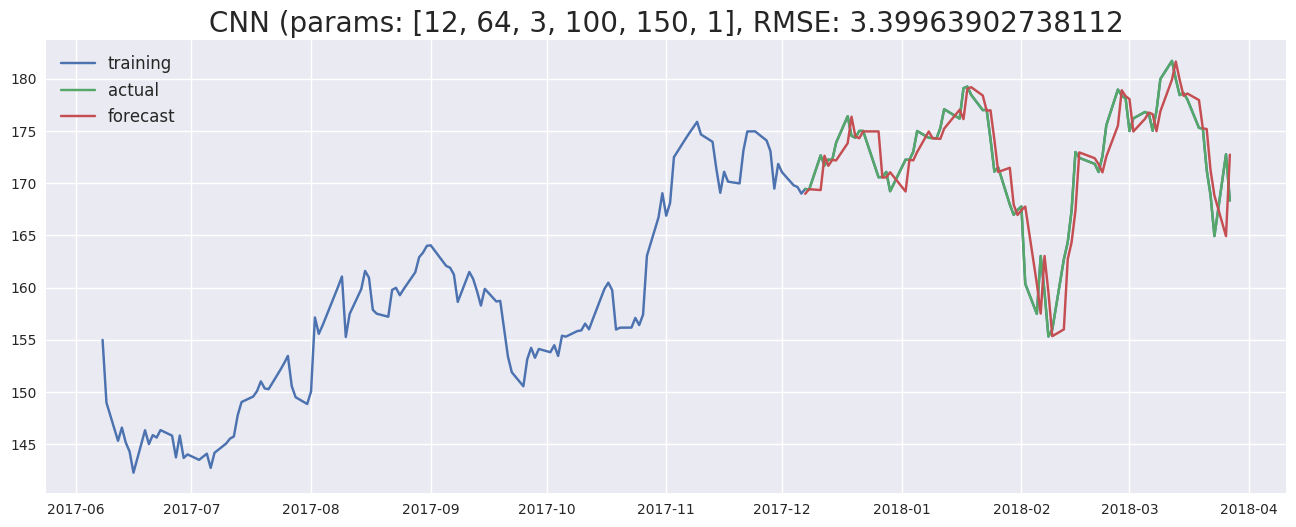

In [48]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(results_df.train[-200:], label='training')
plt.plot(results_df.test, label='actual')
plt.plot(results_df.forecast, label='forecast')
plt.title('CNN (params: {}, RMSE: {}'.format(scores[0][0],scores[0][1]), fontsize = 20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Optimal hyperparameter review
1. 12 lag observation was our only choice for this hyperparameter, might want to add some more values in between.
2. 64 filters was our only choice for this hyperparameter, might want to add some more values in between.
3. Don't have much intuition as to why a kernel size of 5 worked best here. All hail brute force.
4. 100 training epochs was our only choice for this hyperparameter, might want to ad some more values in between.
5. All else equal, a batch size of 150 outperforming batch size of 1 is not too surprising, might want to get more granular with these hyperparameters.
6. Not surprised to see the best config for this I(1) series is differencing once.

### Long Short Term Memory
Below we build a Long Short Term Memory Neural Network
Our LSTM will have one LSTM layer, one dense layer, and we will tune the following hyperparameters by grid search:
1. number of lag observations to use as input to the model.
2. number of LSTM units to use in a higgen layer
3. number of epochs to train
4. number of observations trained after which weights are updated
5. number of time lags to difference on

In [49]:
from keras.layers import LSTM

# fit lstm model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    # reshape sample into [samples, timesteps, features]
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [6, 12]
    n_nodes = [100]
    n_epochs = [50, 100]
    n_batch = [1, 100, 150]
    n_diff = [0, 1]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs


In [50]:
# model configs
cfg_list = model_configs()

Total configs: 24


In [51]:
%%capture
start_time = timeit.default_timer()

# grid search
scores = grid_search(data, cfg_list, n_test)

In [52]:
elapsed = timeit.default_timer() - start_time
print("Grid search took %.3f seconds" % (elapsed))

Grid search took 28585.923 seconds


[6, 100, 50, 150, 1] 2.5997818207252896
[6, 100, 50, 100, 1] 2.607468606977757
[6, 100, 100, 150, 1] 2.771410701719276

 Long Short Term Memory : 3.330 RMSE (+/- 0.514)


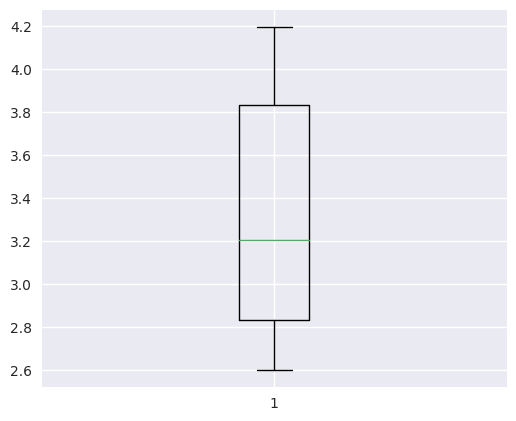

In [53]:
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)
    
# summarize scores
summarize_scores('\n Long Short Term Memory ', scores)

In [54]:
results_df = pd.DataFrame()
cfg_data = {}
top_score = grid_search(data, [ast.literal_eval(scores[0][0])], n_test, plot = True)

> Model[[6, 100, 50, 150, 1]] mean score: 2.591


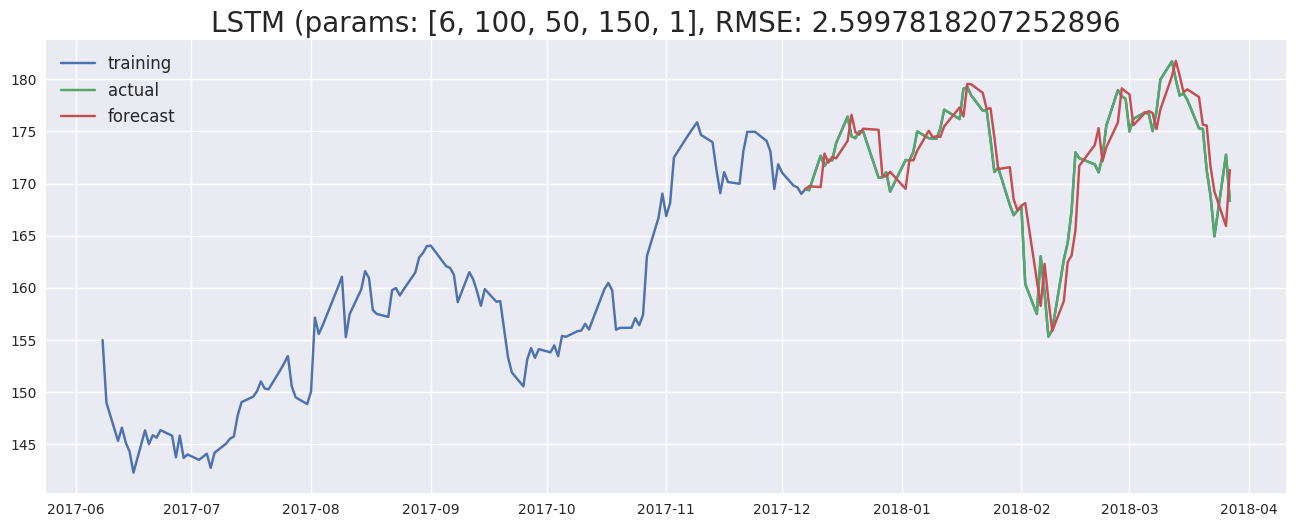

In [55]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(results_df.train[-200:], label='training')
plt.plot(results_df.test, label='actual')
plt.plot(results_df.forecast, label='forecast')
plt.title('LSTM (params: {}, RMSE: {}'.format(scores[0][0],scores[0][1]), fontsize = 20)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Optimal hyperparameter review
1. 6 day lag seemed to outperform 12 day lag, might want to add some more values in between.
2. 100 nodes in our hidden layer was our only choice for this hyperparameter, might want to add some more values in between.
3. 50 training epochs was our only choice for this hyperparameter, might want to add some more values in between.
5. A batch size of 1 outperforming batch size of 150 is a bit surprising, might want to get more granular with these hyperparameters.
6. Not surprised to see the best config for this I(1) series is differencing once.

# Results
After running a range of different models with thousands of hyperparameter configs, here's the best RMSE for each model:<br>

Baseline model: 2.608<br>
Exponential smoothing: 2.6075502884252617<br>
SARIMA: 2.5325551777938515<br>
NN: 2.60484754930078<br>
CNN: 3.39963902738112<br>
LSTM: 2.5997818207252896<br>



### Conclusion
The results were somewhat mixed. The best performing model happened to be SARIMA with the following parameters: [(2, 0, 2), (2, 0, 1, 0), 'ct'], which is unsurprising since it is a very popular and comprehensive time series model. 

Excluding CNN, I am a bit surprised how well our other neural networks did with little consideration of the network topology. However, they did not improve results enough for me to give up the interpretability of the simpler models, especially in the case of the SARIMA.

#### Next steps:
1. Focus more on a narrower set of models
2. Be more systematic about hyperparameter gride search, lot of inconsistency in this project.
3. Spend more time exploring NN, in particular playing more with network topology on one type of NN (e.g. LSTM, CNN, etc.). Plot model training history to check for overfitting.
4. More data prep techniques: standardization, normalization, feature engineering, etc.
5. Update forecasting plots to include confidence intervals.
6. Find better time series to model; stock price data is very difficult.

#### Part 2: Feature engineering for regularized regression model

>Be sure to check out my other related notebook where we will use feature engineering and regularized regression models to try to improve the predictive power and interpretability of our time series models.